**LIBRARY MANAGEMENT**

In [ ]:
!pip install deepdish

# Importing required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import deepdish as dd

**DATA ACQUISITION**

In [ ]:
# Connection with Google Drive for Data Acquisition
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ISIC_Dataset')

Mounted at /content/drive


In [ ]:
# Create a dictionary with images path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for 
                     x in glob(os.path.join('*', '*.jpg'))}

# Dictionary with lesion categories
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
# Merge images with its labels and additional info such as age or sex
tile_df = pd.read_csv('HAM10000_metadata.csv')
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
5754,HAM_0001063,ISIC_0027180,nv,follow_up,60.0,female,abdomen,HAM10000_images_part_1/ISIC_0027180.jpg,Melanocytic nevi,4
2364,HAM_0003862,ISIC_0032775,vasc,histo,45.0,male,upper extremity,HAM10000_images_part_2/ISIC_0032775.jpg,Vascular lesions,6
3408,HAM_0006568,ISIC_0025615,nv,follow_up,45.0,female,abdomen,HAM10000_images_part_1/ISIC_0025615.jpg,Melanocytic nevi,4


**IMAGE PREPROCESSING**

In [ ]:
# Adding and resizing images to dataframe 
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

**EXPLORATORY DATA ANALYSIS (EDA)**

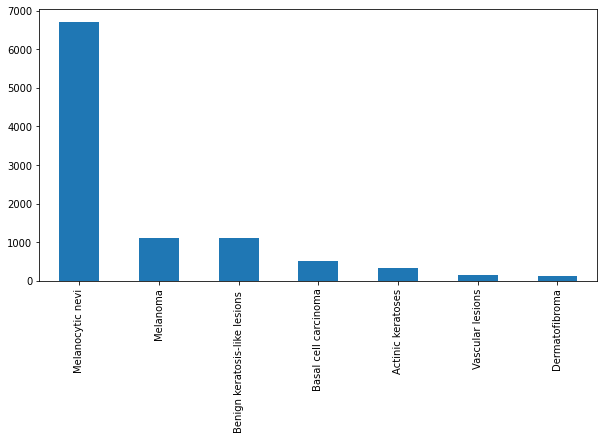

In [ ]:
# Showing number of samples per class
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
# Data null analysis
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
image            0
dtype: int64

In [ ]:
# Null replacement with average age
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

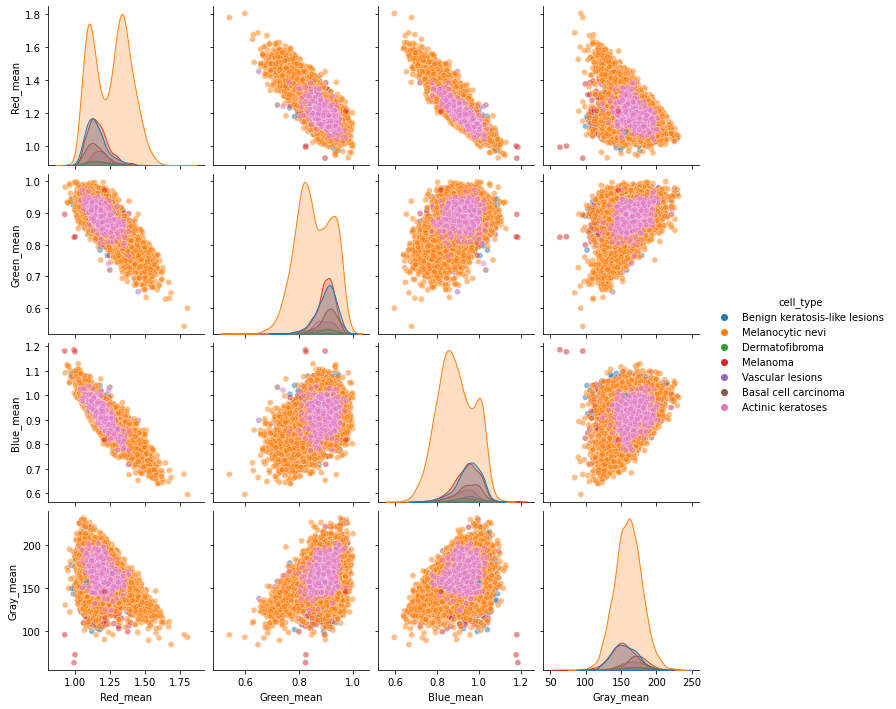

In [ ]:
# Showing relation between classes based on color channels (R,G,B) and gray
rgb_info_df = tile_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
for c_col in rgb_info_df.columns:
    tile_df[c_col] = rgb_info_df[c_col].values # we cant afford a copy
sns.pairplot(tile_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

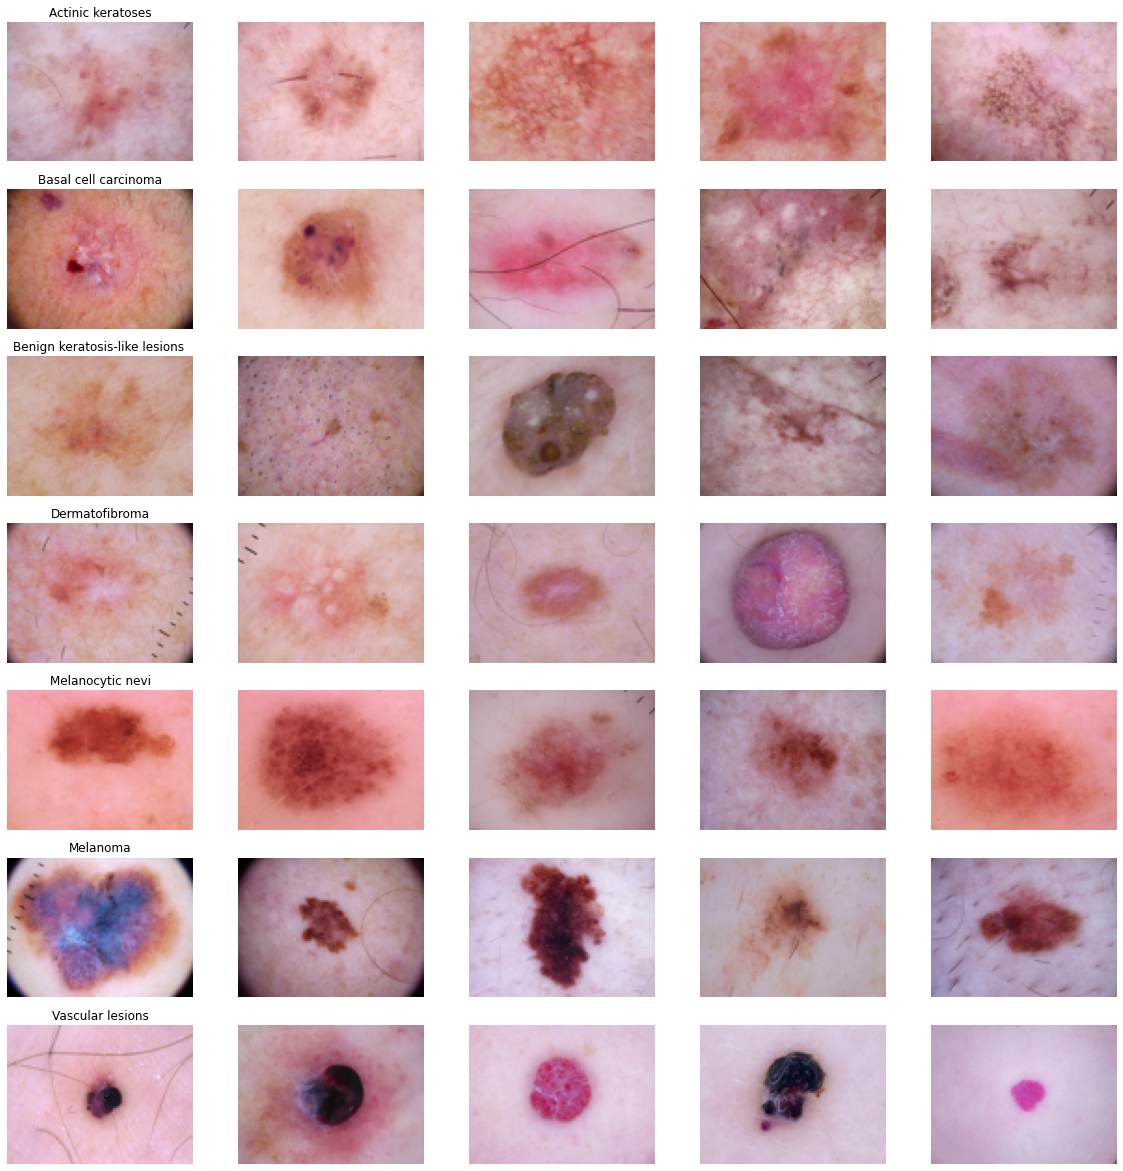

In [ ]:
# Showing some samples for each class
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
# Remove duplicates
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
1622,5,Melanoma
2413,6,Vascular lesions


In [ ]:
# Showing some data from dataset
tile_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image,Red_mean,Green_mean,Blue_mean,Gray_mean
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,...",1.132198,0.882520,0.985282,184.369333
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...",1.114018,0.884647,1.001334,176.972533
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,...",1.179297,0.861713,0.958990,181.516756
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...",1.184910,0.863416,0.951675,165.179289
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ...",1.124235,0.892019,0.983746,188.321911


**SAVING DATA**

In [ ]:
# Saving data into HDF5 file
tile_df.to_hdf('ISIC_dataset.h5', key='tile_df')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'sex', 'localization', 'path',
       'cell_type', 'image'],
      dtype='object')]

  encoding=encoding,
